MVP: Target highest utilized subway stations to optimally place street teams at entrances to increase attendance at WomenTechWomenYes (WTWY) gala event with individuals passionate about increasing participation of women in technology and build awareness. 

Scope of Solution Space: Street teams will collect email addresses and those that sign-up will receive free gala tickets, and ideally attend and contribute to cause. 

Targeted Demographic: Targeted areas should range from high school and university/college students and young and seasoned professionals. 

Key Data Source: MTA Subway Data (http://web.mta.info/developers/turnstile.html) 

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [50]:
def consolidator(weeks):
    """ Pulls CSVs from mta website for each week listed and converts those to pandas dataframes. Dataframes are
        then combined, new columns are added, and rows are filtered.
    Args:
      weeks: list of weeks to combine, formatted as specified on http://web.mta.info/developers/turnstile.html 
    
    Returns:
      concated, cleaned dataframe ready for EDA
    """
    
    dfs = []
    for week in weeks:
        link = f'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{week}.txt'
        dfs.append(pd.read_csv(link, parse_dates =[['date', 'time']], keep_date_col=True, names=columns, skiprows=1))
    df = pd.concat(dfs)
    
    # add date columns
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date_time'].dt.day_name()
    df['week'] = df['date_time'].dt.week
    # filter rows:
    df = df[(df['division'].isin(['BMT', 'IND', 'IRT']) 
         & df.time.astype(str).str.contains('00:00'))]

    # sort
    df.sort_values(['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True, ascending=False)
    
    #dd
    df.drop_duplicates(subset=['c/a', 'unit', 'scp', 'station', 'date_time'], inplace=True)#.reset_index()
    ## groupby station to find prev_entries 
    df.reset_index(drop=True, inplace=True)
    df[['prev_date', 'prev_exits']] = (df.groupby(['c/a', 'unit', 'scp', 'station'])
                                           ['date', 'exits'].apply(lambda x: x.shift(-1)))
    
    # exits tally 
    df['out'] = df['exits'] - df['prev_exits']
    # drop first date nulls
    df.dropna(subset=['prev_exits'], axis=0, inplace=True)
    df = df[(df['out'] > 0) & (df['out'] < 100000)]
    return df

In [51]:
#August 17, 2019 - September 21, 2019
weeks = [190824, 190831, 190907, 190914, 190921]

# rename columns 
columns = ['c/a', 'unit', 'scp', 'station', 'linename', 'division', 'date', 
           'time', 'desc', 'entries', 'exits']


In [52]:
# exits per scp per hour
df = consolidator(weeks)

# exits by station per day
df_daily = df.groupby(['date', 'station'])['out'].sum().reset_index()

# exits by station per hour
df_hourly = df.groupby(['date_time', 'station'])['out'].sum().reset_index()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


In [53]:
# df for 59th st daily
mask59_d = (df_daily['station'] == '59 ST')
daily_59 = df_daily[mask59_d]

# df for 59th st hourly saturday to friday
mask59_h = (df_hourly['station'] == '59 ST')
hourly_59 = df_hourly[mask59_h]

# df for 1 week of 59th st hourly traffic
mask_59_hw = (df_hourly['station'] == '59 ST') & (df_hourly['date_time'] >= '2019-09-07 04:00:00') & (df_hourly['date_time'] <= '2019-09-14 00:00:00')
week_hourly_59 = df_hourly[mask_59_hw]

# df for 1 day of 59th st hourly traffic (monday september 9)
mask_59_monday = (df_hourly['station'] == '59 ST') & (df_hourly['date_time'] >= '2019-09-09 04:00:00') & (df_hourly['date_time'] <= '2019-9-10 00:00:00')
monday_59 = df_hourly[mask_59_monday]

mask_fm_monday = (df_hourly['station'] == 'FLUSHING-MAIN') & (df_hourly['date_time'] >= '2019-09-09 04:00:00') & (df_hourly['date_time'] <= '2019-09-10 00:00:00')
monday_fm = df_hourly[mask_fm_monday]


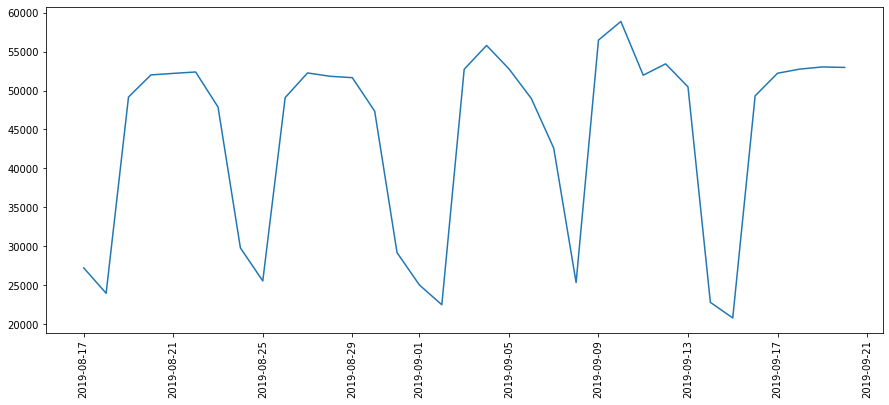

In [54]:
# Plot for daily 59th st traffic
plt.figure(figsize = [15,6])
plt.xticks(rotation=90)
plt.plot(daily_59['date'], daily_59['out']);


''

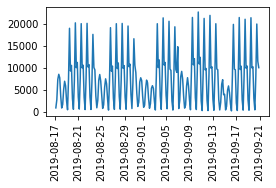

In [55]:
# Plot for hourly 59th st traffic

plt.figure(figsize = [4,2])
plt.plot(hourly_59['date_time'], hourly_59['out'])
plt.xticks(rotation='vertical')
;

''

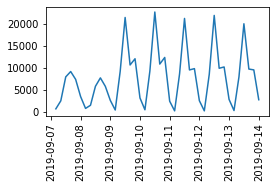

In [56]:
# plot for 1 week hourly traffic at 59th st

plt.figure(figsize = [4,2])
plt.plot(week_hourly_59['date_time'], week_hourly_59['out'])
plt.xticks(rotation='vertical')
;

''

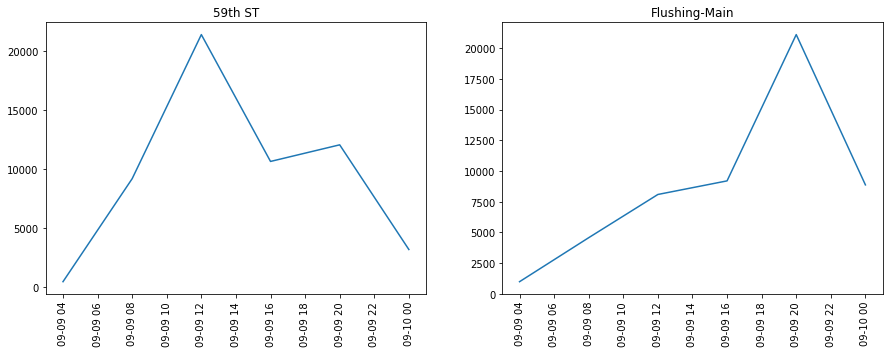

In [57]:
# plot for 1 day traffic 59th st & Flushing-Main (monday sept 30)   (notice swap in rush hour traffic )
plt.figure(figsize = [15,5])

plt.subplot(1,2,1)
plt.plot(monday_59['date_time'], monday_59['out'])
plt.title('59th ST')
plt.xticks(rotation='vertical')

plt.subplot(1,2,2)
plt.plot(monday_fm['date_time'], monday_fm['out'])
plt.title('Flushing-Main')
plt.xticks(rotation='vertical')
;

In [58]:
# loop / fxn for multiple plots?
stations = ['59 ST', 'FLUSHING-MAIN']

In [59]:
flushingmask = df

In [60]:
# setting as_index to false prevents station names from becoming index and allows to remain as column 
df_station_total2 = df.groupby('station', as_index=False).out.sum()
top_station_mask = df_station_total2["out"]>700000
top_stations = df_station_total2[top_station_mask]
top_stations = top_stations.sort_values(['out'], ascending=False)
top_stations

,station,out
58,34 ST-PENN STA,4359604.0
226,GRD CNTRL-42 ST,3707181.0
56,34 ST-HERALD SQ,3562879.0
14,14 ST-UNION SQ,2874787.0
329,TIMES SQ-42 ST,2813084.0
65,42 ST-PORT AUTH,2536614.0
43,23 ST,2530408.0
219,FULTON ST,2499681.0
107,86 ST,2324764.0
9,125 ST,2019948.0


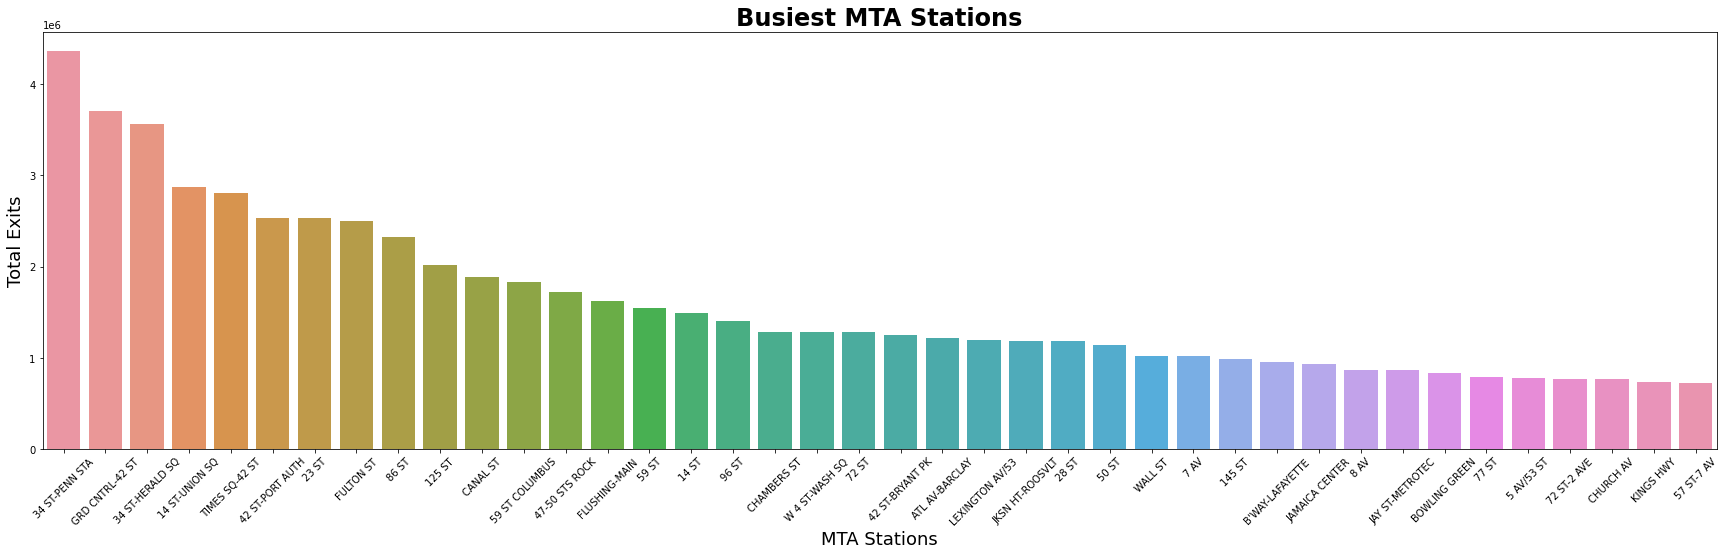

In [61]:
plt.figure(figsize=(30,10))
top_stations_chart = sns.barplot(x='station', y='out', data=top_stations.reset_index())
top_stations_chart.set_xticklabels(top_stations_chart.get_xticklabels(), rotation=45)
plt.xlabel('MTA Stations', fontsize=18)
plt.ylabel('Total Exits', fontsize=18)
plt.title("Busiest MTA Stations", fontsize=24, weight='bold')
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('top_stations_by_out');

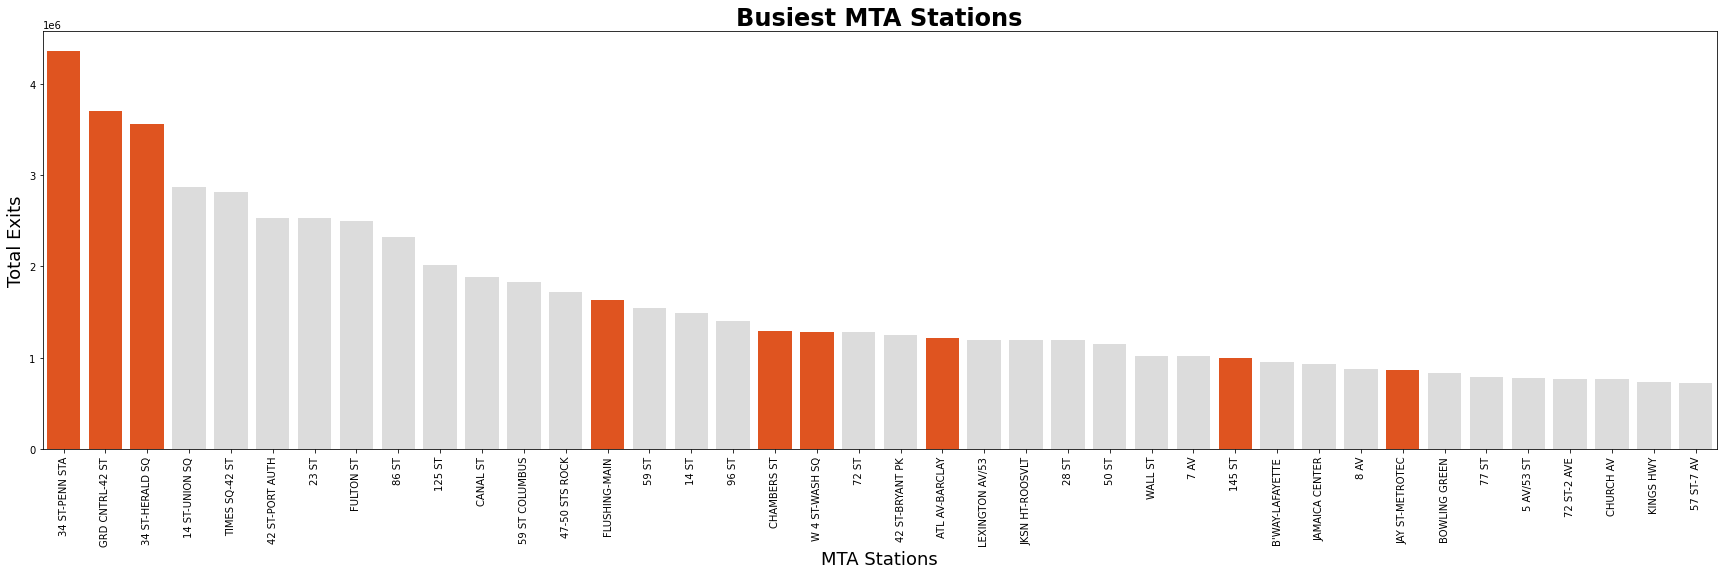

In [62]:
stat = ['34 ST-PENN STA', 'GRD CNTRL-42 ST', '34 ST-HERALD SQ', 'W 4 ST-WASH SQ', 'CHAMBERS ST', '145 ST', 'FLUSHING-MAIN', 'ATL AV-BARCLAY', 'JAY ST-METROTEC']

plt.figure(figsize=(30,10))
top_stations_chart2 = sns.barplot(x='station', y='out', data=top_stations.reset_index(), palette=['orangered' if x in stat else 'gainsboro' for x in top_stations['station']])
top_stations_chart2.set_xticklabels(top_stations_chart2.get_xticklabels(), rotation=90)
#top_stations_chart2.set_color('r')
sns.set_color_codes('muted')
plt.xlabel('MTA Stations', fontsize=18)
plt.ylabel('Total Exits', fontsize=18)
plt.title("Busiest MTA Stations", fontsize=24, weight='bold')
plt.gcf().subplots_adjust(bottom=0.30)
plt.savefig('top_stations_by_out_highlight');

In [63]:
 '34 ST-PENN STA' or x == 'GRD CNTRL-42 ST' 

'34 ST-PENN STA'

In [64]:
# create a mask to filter one particular station 
station_mask_34_PENN = df['unit']=='R012' # mask using unit rather than station because there are multiple 34 PENN 
# apply mask, creates new DF consisting of data for a single station 
station_34_PENN = df[station_mask_34_PENN]
# create a list of exit counts by time 
station_34_PENN_time_list = list(station_34_PENN.groupby(['time']).out.sum())

# repeat for other select top stations 
station_mask_GRD_CNTRL_42 = df['unit']=='R046' # mask using unit rather than station because there are multiple GRD CNTRL 42
station_GRD_CNTRL_42 = df[station_mask_GRD_CNTRL_42]
station_GRD_CNTRL_42_time_list = list(station_GRD_CNTRL_42.groupby(['time']).out.sum())

station_mask_34_HERALD = df['station']=='34 ST-HERALD SQ'
station_34_HERALD = df[station_mask_34_HERALD]
station_34_HERALD_time_list = list(station_34_HERALD.groupby(['time']).out.sum())

station_mask_FLUSHING_MAIN = df['station']=='FLUSHING-MAIN'
station_FLUSHING_MAIN = df[station_mask_FLUSHING_MAIN]
station_FLUSHING_MAIN_time_list = list(station_FLUSHING_MAIN.groupby(['time']).out.sum())

station_mask_ATL_BARCLAY = df['station']=='ATL AV-BARCLAY'
station_ATL_BARCLAY = df[station_mask_ATL_BARCLAY]
station_ATL_BARCLAY_time_list = list(station_ATL_BARCLAY.groupby(['time']).out.sum())

station_mask_JAY_METRO = df['station']=='JAY ST-METROTEC'
station_JAY_METRO = df[station_mask_JAY_METRO]
station_JAY_METRO_time_list = list(station_JAY_METRO.groupby(['time']).out.sum())

station_mask_W_4ST = df['station']=="W 4 ST-WASH SQ"
station_W_4ST = df[station_mask_W_4ST]
station_W_4ST_time_list = list(station_W_4ST.groupby(['time']).out.sum())

station_mask_CHAMBERS = df['station']=='CHAMBERS ST'
station_CHAMBERS = df[station_mask_CHAMBERS]
station_CHAMBERS_time_list = list(station_CHAMBERS.groupby(['time']).out.sum())

station_mask_145 = df['station']=='145 ST'
station_145 = df[station_mask_145]
station_145_time_list = list(station_145.groupby(['time']).out.sum())

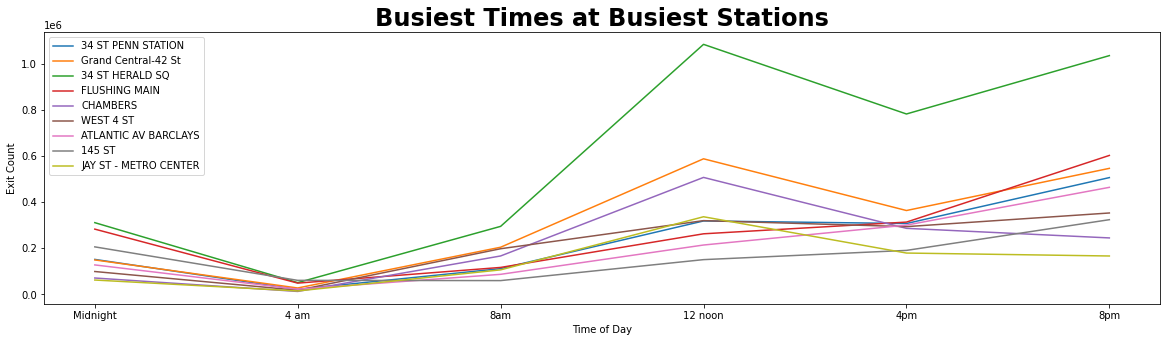

In [65]:
plt.figure(figsize=(20,5))
plt.plot(station_34_PENN_time_list)
plt.plot(station_GRD_CNTRL_42_time_list)
plt.plot(station_34_HERALD_time_list)
plt.plot(station_FLUSHING_MAIN_time_list)
plt.plot(station_CHAMBERS_time_list)
plt.plot(station_W_4ST_time_list)
plt.plot(station_ATL_BARCLAY_time_list)
plt.plot(station_145_time_list)
plt.plot(station_JAY_METRO_time_list)

plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['34 ST PENN STATION', 'Grand Central-42 St', '34 ST HERALD SQ', 'FLUSHING MAIN', 'CHAMBERS', 'WEST 4 ST', 'ATLANTIC AV BARCLAYS', '145 ST','JAY ST - METRO CENTER'])
plt.title("Busiest Times at Busiest Stations", fontsize=24, weight='bold')
plt.savefig('nine_featured_stations_by_time');

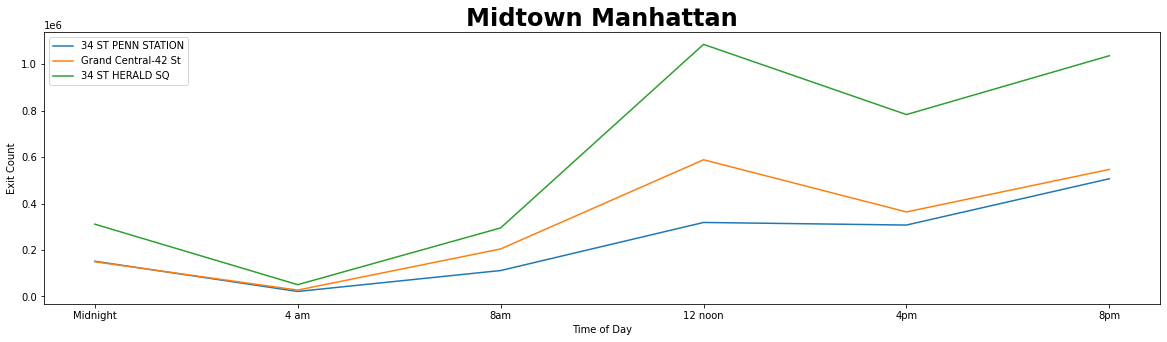

In [66]:
# JUST MIDTOWN
plt.figure(figsize=(20,5))
plt.plot(station_34_PENN_time_list)
plt.plot(station_GRD_CNTRL_42_time_list)
plt.plot(station_34_HERALD_time_list)
plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['34 ST PENN STATION', 'Grand Central-42 St', '34 ST HERALD SQ'])
plt.title("Midtown Manhattan", fontsize=24, weight='bold')
plt.savefig('midtown_manhattan');

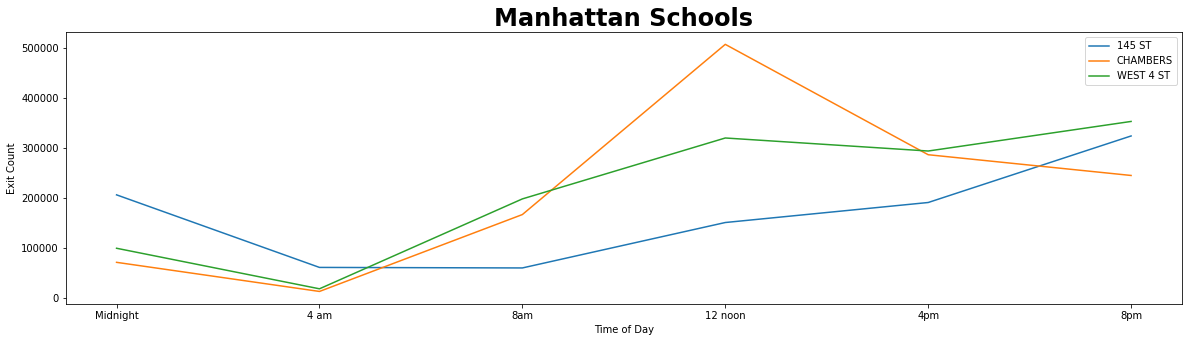

In [67]:
# MANHATTAN SCHOOLS 
plt.figure(figsize=(20,5))
plt.plot(station_145_time_list)
plt.plot(station_CHAMBERS_time_list)
plt.plot(station_W_4ST_time_list)
plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['145 ST', 'CHAMBERS', 'WEST 4 ST',])
plt.title("Manhattan Schools", fontsize=24, weight='bold')
plt.savefig('manhattan_schools');

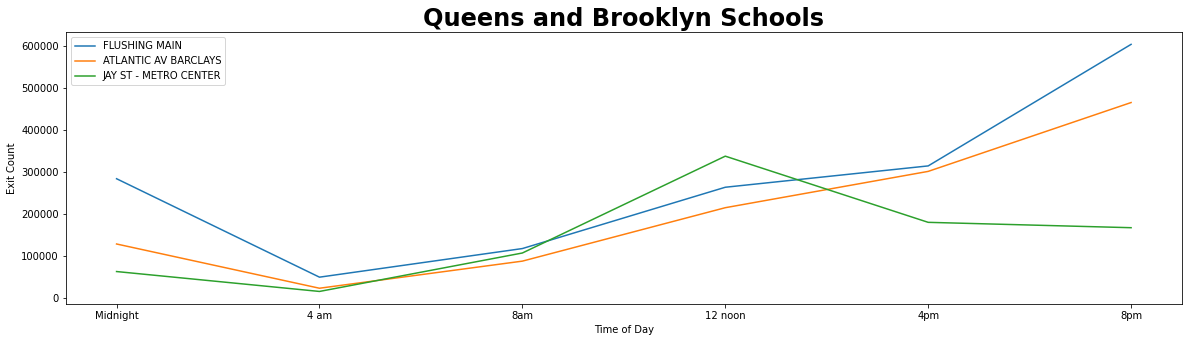

In [68]:
# QUEENS AND BROOKLYN SCHOOLS 
plt.figure(figsize=(20,5))
plt.plot(station_FLUSHING_MAIN_time_list)
plt.plot(station_ATL_BARCLAY_time_list)
plt.plot(station_JAY_METRO_time_list)
plt.xlabel("Time of Day")
plt.ylabel("Exit Count")
ticks_x = [0,1,2,3,4,5]
x_labels = ['Midnight', '4 am', '8am', '12 noon', '4pm', '8pm']
plt.xticks(ticks=ticks_x, labels=x_labels)
plt.legend(['FLUSHING MAIN', 'ATLANTIC AV BARCLAYS', 'JAY ST - METRO CENTER'])
plt.title("Queens and Brooklyn Schools", fontsize=24, weight='bold')
plt.savefig('queens_brooklyn_schools');

In [71]:
# Traffic before and after labor day at stations near large schools:

# df for JAY ST-METROTEC  daily
maskjay_d = (df_daily['station'] == 'JAY ST-METROTEC')
daily_jay = df_daily[maskjay_d]

# df for w 4th wash sq daily
maskws_d = (df_daily['station'] == 'W 4 ST-WASH SQ')
daily_ws = df_daily[maskws_d]

# df for w Chambers St daily
maskcs_d = (df_daily['station'] == 'CHAMBERS ST')
daily_cs = df_daily[maskcs_d]

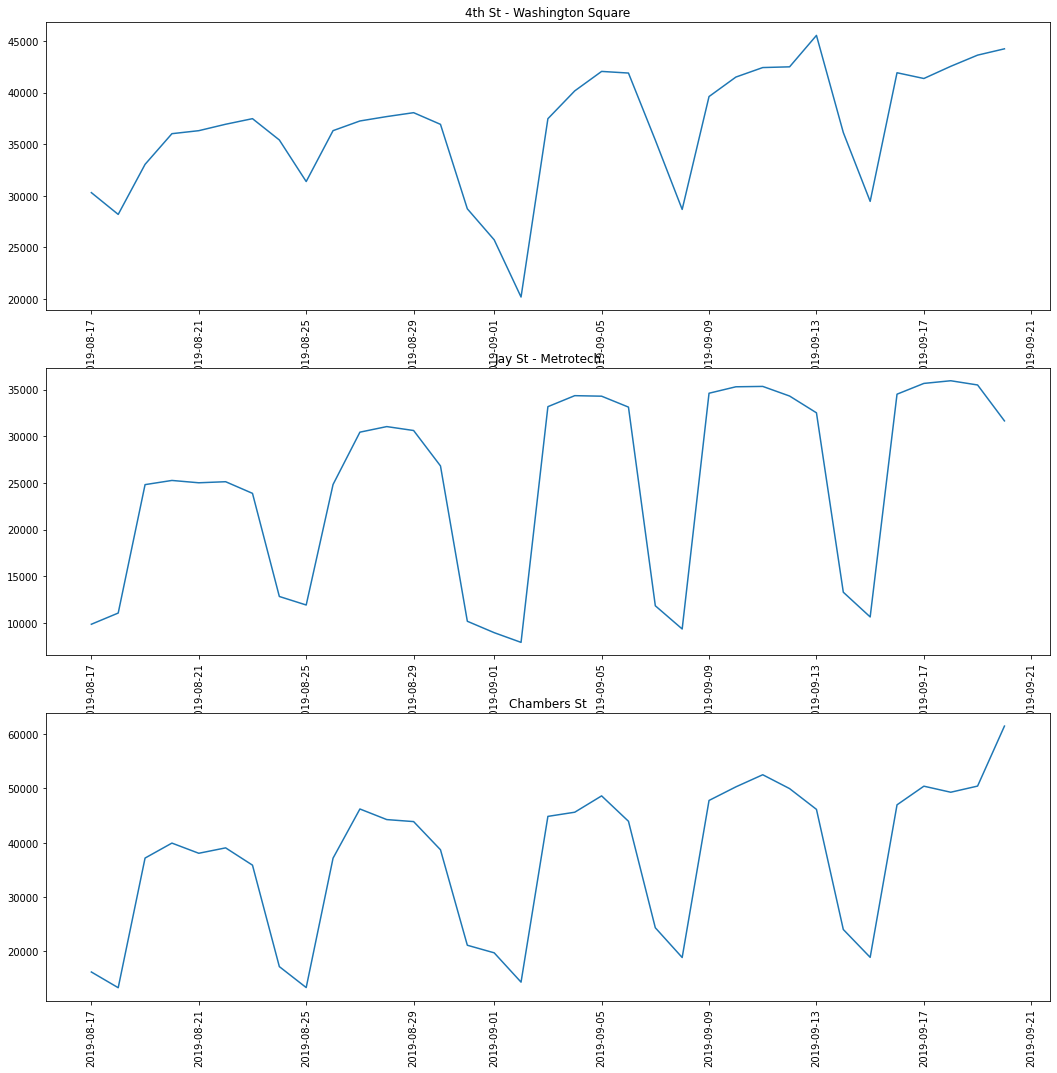

In [72]:
# subplots for jay_st, 4th st / wash, chambers
# illustrates boost in traffic after labor day that may be related to school starting

plt.figure(figsize=[18,18])

plt.subplot(3, 1, 1)

plt.xticks(rotation=90)
plt.title('4th St - Washington Square')
plt.plot(daily_ws['date'], daily_ws['out']);

plt.subplot(3, 1, 2)
# plot for jay st metro tech

plt.xticks(rotation=90)
plt.title('Jay St - Metrotech')
plt.plot(daily_jay['date'], daily_jay['out']);

plt.subplot(3, 1, 3)

plt.xticks(rotation=90)
plt.title('Chambers St')
plt.plot(daily_cs['date'], daily_cs['out']);

plt.savefig('labor_day_boost')